### Make a plot TSeries for ASC and T

### CORRELATION FUNCTION

In [1]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

## Loading the basics

In [2]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import gsw
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [3]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37549,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:44949,Total threads: 4
Dashboard: /proxy/36019/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:34851,


In [4]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

### Creating variables for time series

### temperature

In [5]:
# load temperature data at 400m:

depth_slice = slice(400, 6000)
# cut the data BOX 1
lon_slice  = slice(-252.7, -251.7)
lat_slice  = slice(-65.35, -65.1)

temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

In [6]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 400
zlevel2 = 6000

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(iaf_cycle3,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_400m.yt_ocean,'xt_ocean':temp_400m.xt_ocean},axis=[1,2])
# import bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'ht',master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(iaf_cycle3,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))

# multiply by thickness to avg
temp_400m = (temp_400m*thickness).sum('st_ocean')/thickness.sum('st_ocean')

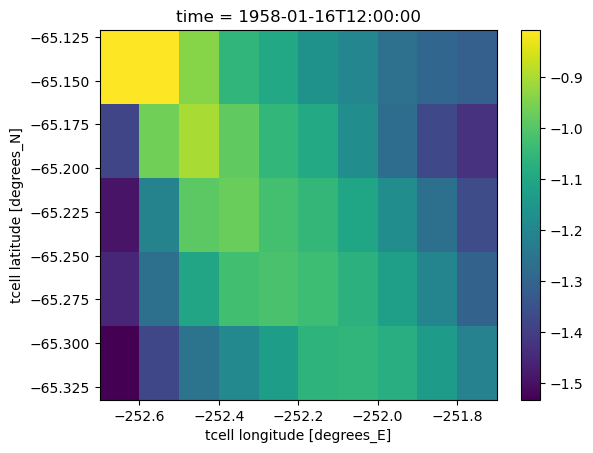

In [7]:
##test if temp is still working after the depth weighting
temp_400m[0,...].plot()

In [8]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_t = cc.querying.getvar('01deg_jra55v13_ryf9091','area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# sum area:
area_t_sum = area_t.sum('xt_ocean').sum('yt_ocean')

# Apply area weight:
temp_400m = (temp_400m*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum


In [9]:
temp_400m = temp_400m.load()

#### Detrend time series and apply rolling mean 

In [10]:
# Note we need to first detrend the data:
temp_400m_zadr = detrend_dim(temp_400m,'time')
temp_400m_zadr = temp_400m_zadr.rolling(time=12, center=True).mean()
temp_400m_r = temp_400m.rolling(time=12, center=True).mean()

## LOAD SPEED

### ASC SPEED USING TRANSECT LINE

In [11]:
# depth limits chosen based on transects
depth_slice = slice(200, 500)
# set this to the rough region of interest:
#lat_slice  = slice(-65.5,-65.4)
#lat_slice  = -65
lon_slice  = slice(-257, -244)
lat_slice  = slice(-69, -62)
#get U general 
u_speed = cc.querying.getvar(iaf_cycle3,'u',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3

In [12]:
# load a sample slice of data to plot just for testing:
#temp_slice = temp.sel(st_ocean=400,method='nearest').isel(time=0)
u_slice = u_speed.sel(st_ocean=400,method='nearest').mean('time')
u_slice = u_slice.load()

# also get bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
ht = ht.load()

In [13]:
u_slice

<xarray.DataArray 'u' (yu_ocean: 162, xu_ocean: 130)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.03737195, 0.0378098 , 0.03791826, ..., 0.09607346, 0.10108948,
        0.10572767],
       [0.03701345, 0.03772001, 0.03762305, ..., 0.09057091, 0.09533705,
        0.09976057],
       [0.03657711, 0.03750196, 0.03735018, ..., 0.08403323, 0.08837038,
        0.09274587]], dtype=float32)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -257.0 -256.9 -256.8 ... -244.3 -244.2 -244.1
  * yu_ocean  (yu_ocean) float64 -68.96 -68.92 -68.88 ... -62.1 -62.05 -62.01
    st_ocean  float64 383.0

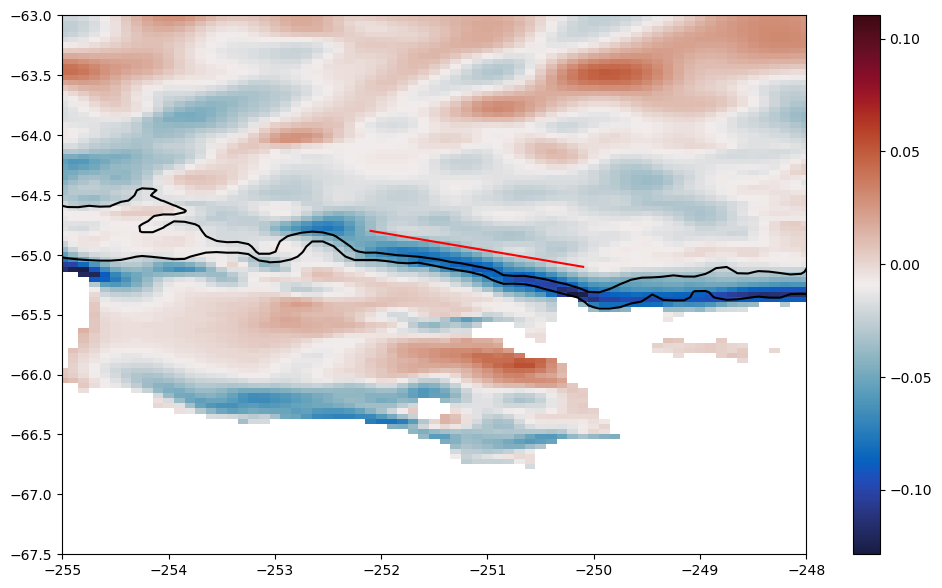

In [14]:
# define transect start and end points:
# Change these values until you get the transect you want:
lat0 = -64.8 #64.8
lat1= -65.1 #65.1
lon0 = -252.1 #252.1
lon1 = -250.1 #250.1

plt.figure(figsize=(12,7))

# plot temperature:
plt.pcolormesh(u_slice.xu_ocean,u_slice.yu_ocean,u_slice, cmap=cmocean.balance)#,
#              vmin=-2,vmax=1)
plt.colorbar()
#plt.clim((-2.1,.8))

# plot transect location:
plt.plot([lon0,lon1],[lat0,lat1],'r')
plt.xlim((-255, -248))
plt.ylim((-67.5, -63))
# plot bathymetry contours:
i=plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[1000,2000],colors='k')

#save_results_to = '/g/data/jk72/ns3783/Round8'
#plt.savefig(save_results_to + 'transect_lat_IAF3.png', dpi=120,bbox_inches='tight', pad_inches=0.1)
#plt.savefig(save_results_to + 'transect_asc_trajectory+temp.png', dpi=120,bbox_inches='tight', pad_inches=0.1)

In [15]:
# Note that this cell is slow, but it will load the entire timeseries along the transect 
# (which means you could later make movies of this or look at different snapshots):
lons = [lon0, lon1]
lats = [lat0, lat1]

yu_ocean = u_speed.yu_ocean


# get latitude of points along transect:
lat_transect = yu_ocean.sel(yu_ocean = slice(lats[1],lats[0])).values

# calculate slope and intercept of transect line:
slope = (lons[0] - lons[1])/(lats[0]-lats[1])
intercept = lons[0] - slope * lats[0]

# get longitude along transect and convert to xarray:
lon_transect = slope * lat_transect + intercept
lon_transect = xr.DataArray(lon_transect, dims = 'yu_ocean')

# convert to xarray:
lat_transect = xr.DataArray(lat_transect, dims = 'yu_ocean')

# Extract temp and salt along transect:
u_transect = u_speed.sel(xu_ocean = lon_transect, yu_ocean = lat_transect, method = 'nearest')

u_transect = u_transect.load()

In [16]:
#u_transect

In [17]:
u_transect=u_transect.mean('yu_ocean').mean('st_ocean')

#### Detrend time series both ASC heat flux X and speed time series

In [18]:
#asc_X_d = detrend_dim(asc_heat_x,'time')
u_speed_td = detrend_dim(u_transect,'time')

#### Apply Rolling mean to them 

In [19]:
#asc_X_dr = asc_X_d.rolling(time=12, center=True).mean()
u_speed_tdr = u_speed_td.rolling(time=12, center=True).mean()

In [20]:
u_speed_tr = u_transect.rolling(time=12, center=True).mean()

### compute correlation

In [21]:
# This computes the cor: era lag x=6
cov,cor_temp,slope,intercept,pval_temp,stderr = lag_linregress_3D(temp_400m_zadr,u_speed_tdr,lagx=0, lagy=0)

In [22]:
cor_temp

<xarray.DataArray ()>
array(0.42730167)

### PLOT TIME SERIES FOR FIGURE 

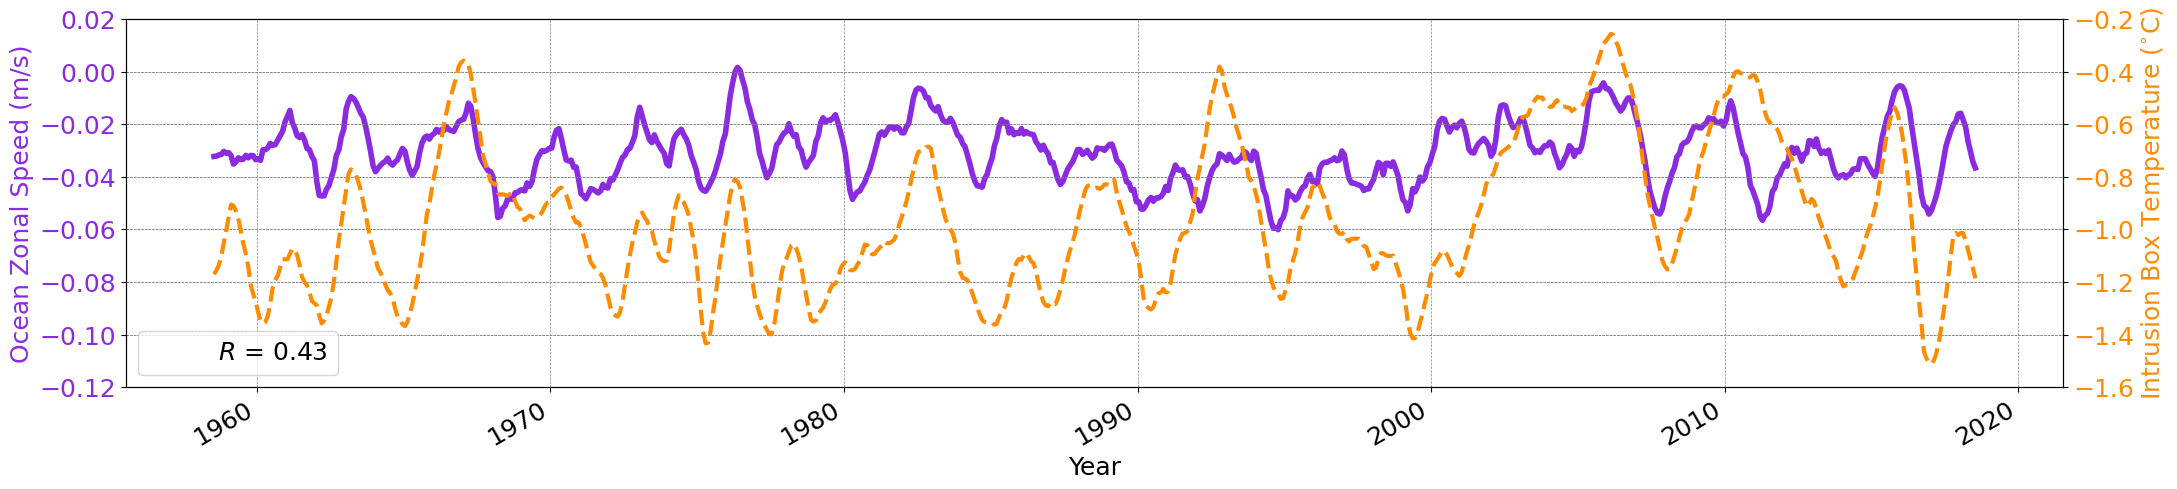

In [27]:
fontsize=18
fig=plt.figure(figsize=(25, 22))
fig.subplots_adjust(top=0.88)


ax1 = plt.subplot(4, 1, 1)
u_speed_tr.plot(color='blueviolet',linewidth=4)
ax1.set_ylabel('Ocean Zonal Speed (m/s)', fontsize=fontsize,color='blueviolet')
ax1.tick_params(axis='y', labelcolor='blueviolet',labelsize=fontsize)
ax1.set_xlabel('Year', fontsize = fontsize)
ax1.tick_params(axis='x',labelsize=fontsize)
#plt.title('Monthly T (Box1) vs Zonal Wind (small grid; -65,-64.5S/-258,-252E) / Rolling mean',fontsize=fontsize)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylim([-0.12,0.02])
#plt.text(100,0.4,"cor = -0.73, lag = 4 months")

ax2 = ax1.twinx()
#isocon_off_dr.plot(color='C0')
temp_400m_r.plot(color='darkorange',linestyle='--',linewidth=3)
#isocon_off3_dr.plot(color='C0',linestyle=':')
ax2.set_ylabel('Intrusion Box Temperature ($^{\circ}$C)', fontsize=fontsize, color='darkorange')
ax2.tick_params(axis='x',labelsize=fontsize)
ax2.tick_params(axis='y', labelcolor='darkorange',labelsize=fontsize)
#ax2.invert_yaxis()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.text(700, -0.4, 'cor=0.016', fontsize = 12)
#building legend
#plt.plot(np.nan,np.nan,color='C0',linestyle=':',label='27.80')
plt.plot(np.nan,np.nan,color='k',linestyle='none',label='$R$ = 0.43')
#plt.plot(np.nan,np.nan,color='C0',label='27.83')
plt.legend(loc="lower left",fontsize=fontsize)
plt.ylim([-1.6,-0.2])


figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
filestr = figdir+'/fig6_temp_vsASC_time_series.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')